## DImensionality reduction and manifold learning (embeddings)
* Today we are going to learn how to visualize and explore the data
![pictcha](http://sarahannelawless.com/wp-content/uploads/2015/03/tw-1-600x449.jpg)

In [21]:
from time import time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

### Load digits
 * A thousand something 8x8 handwritten digits

In [22]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
X = digits.data
y = digits.target
n_samples, n_features = X.shape


In [23]:
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


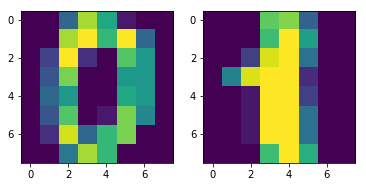

In [24]:
# a few testimonials
plt.subplot(1,2,1)
plt.imshow(X[0].reshape(8,8))
plt.subplot(1,2,2)
plt.imshow(X[1].reshape(8,8))

### Data visualization

Here's an overly complicated function that draws any two-dimensional space you want

In [25]:
from matplotlib import offsetbox
def plot_embedding(X,y=None,ax=None,show_images=True,min_dist=5e-3,figsize=[12,10]):
    
    #normalize
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if ax is None:
        plt.figure(figsize=figsize)
        ax = plt.subplot(1,1,1)

    # scatter-plot
    if y is None:
        plt.scatter(*X.T)
    else:
        assert y is not None
        #рисуем циферки a-la scatter
        for i in range(X.shape[0]):
            ax.text(X[i, 0], X[i, 1], str(y[i]),
                     color= plt.cm.Set1(y[i] / 10.),
                     fontdict={'weight': 'bold', 'size': 9})

    if not show_images:
        return
        
    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < min_dist: continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
            X[i])
        ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])


### GaussianRandomProjection
 * Pick several random axes from normal distribution
 * Projects data to these axis
 * Mostly useless for our task.

In [26]:
from sklearn.random_projection import GaussianRandomProjection

Xrp = GaussianRandomProjection(n_components=2).fit_transform(X)

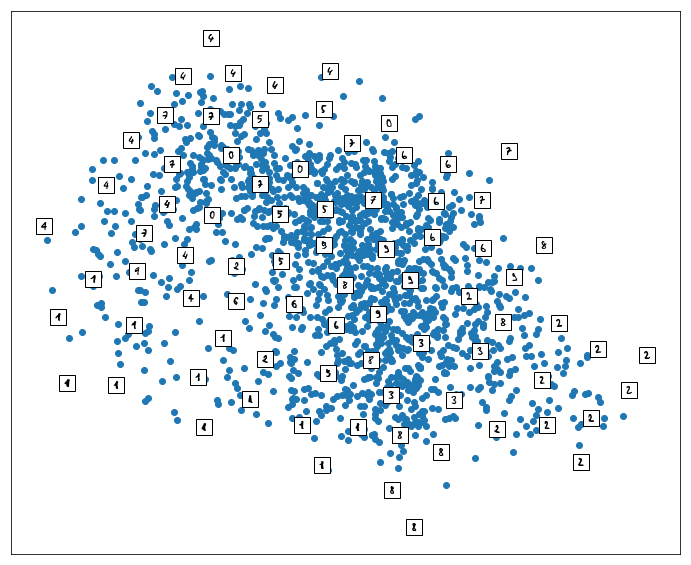

In [27]:
plot_embedding(Xrp)

### Wut?!
Not super helpful to say the least.

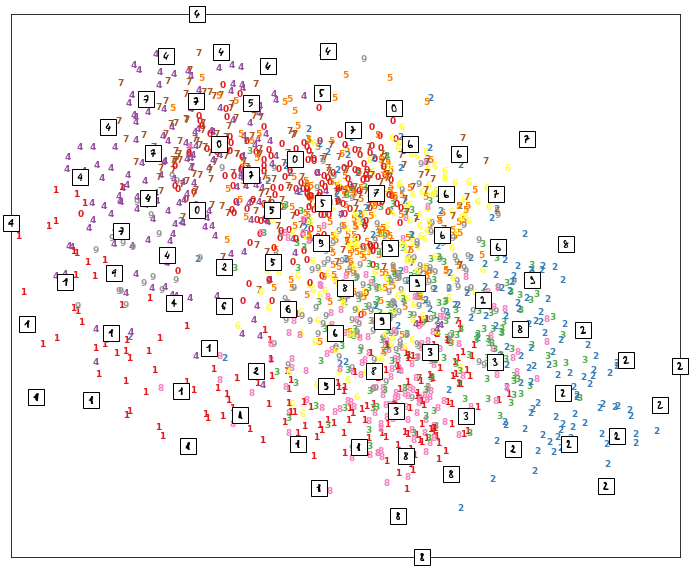

In [28]:
plot_embedding(Xrp,y)

Random projections will change if you re-run code.

### Singular Value Decomposition

* Idea: try to compress the data in a way that you can then restore it
* Equivalent to minimizing MSE: $|| X  - U \cdot \Sigma \cdot V^T ||$

In [29]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
Xsvd = svd.fit_transform(X)

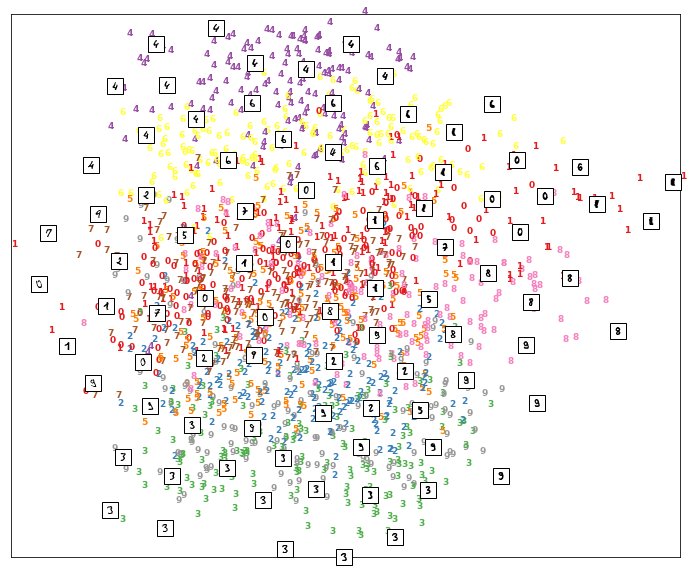

In [30]:
plot_embedding(Xsvd[:,:2],y)

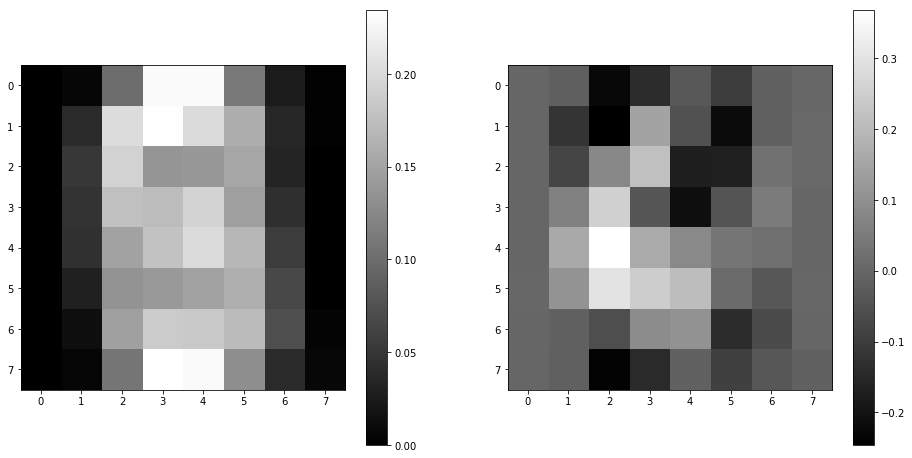

In [31]:
n = svd.n_components
plt.figure(figsize=[16,8])
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(svd.components_[i].reshape(8,8),
              cmap='gray',interpolation='none')
    plt.colorbar()


### PCA aka Principial Component Analysis
* Idea: we try to find axes that "explain as much variance as possible"
* Mathematically it's almost the same as SVD
* But we'll make you train it anyway

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

Xpca = pca.fit_transform(X)

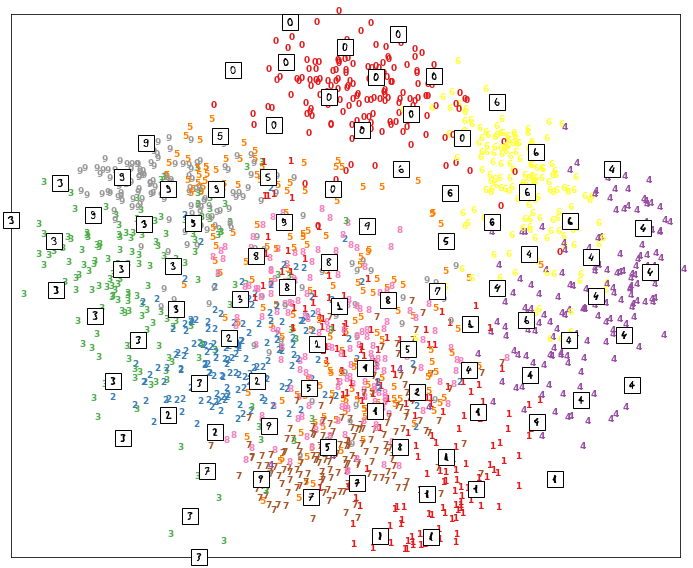

In [33]:
plot_embedding(Xpca,y)

#### Let's not compare all 3...

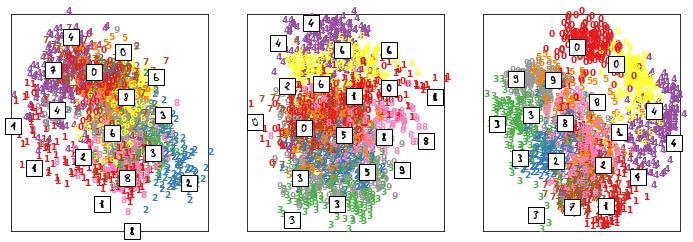

In [34]:
plt.figure(figsize=[12,4])
plot_embedding(Xrp,y,ax=plt.subplot(1,3,1),min_dist=3e-2)
plot_embedding(Xsvd,y,ax=plt.subplot(1,3,2),min_dist=3e-2)
plot_embedding(Xpca,y,ax=plt.subplot(1,3,3),min_dist=3e-2)

# LDA aka Linear Discriminant Analysis

* Idea: let's find axes that allow us to better separate signal from background.
* Unlike PCA, this guy actually needs Y data. So you'll have to fit(X,y).


In [35]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)
Xlda = lda.fit_transform(X,y)

/opt/conda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


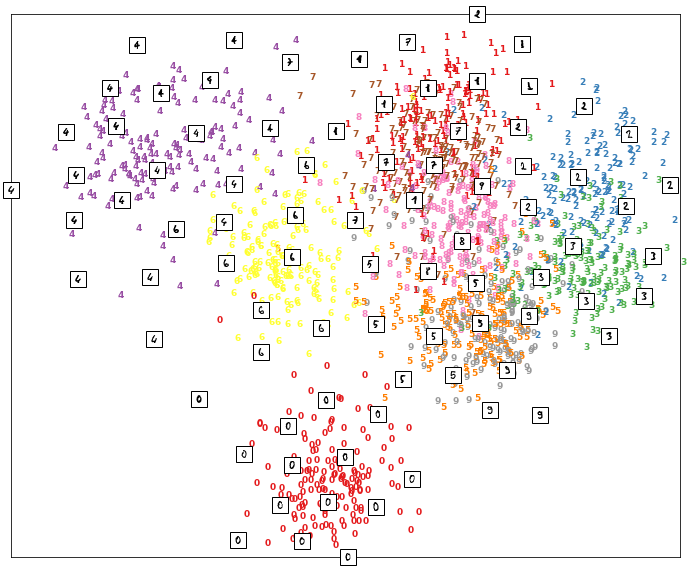

In [36]:
plot_embedding(Xlda,y)

#### We won!

##### Okay, time to make things a bit more complex

__Scroll back to the first tab, find the load_digits function and change n_class to 10__

Then re-run everything.

```

```

```

```

```

```

```

```

```

```

```

```

```

```



# Embedding aka Manifold learning

* Instead of finding linear axes, try to just every image with 2D point in a dictionary fashion.

* General idea: assign images with 2d points to minimize some structural error. Each algorithm uses it's own error metric.

### Multidimensional Scaling

* Idea: assign similar images into close points and keep different images at distance.

#####  More complicated
* We try to preserve euclidian distance
  * Images can be represented as pixel vectors with euclidian distance defined as
$$ r(a,b) = \sqrt { (a_0 - b_0)^2 + (a_1 - b_1)^2 + ... + (a_63 - b_63)^2}$$
  * Our new points are two-dimensional, with 2d euclidian distance
$$ r_{new}(a',b') = \sqrt { (a'_x - b'_x)^2 + (a'_y - b'_y)^2 } $$

  * We want $r_{new}$ to be close to $r$
  * Move $a'$ and $b'$ to minimize MSE:
$$ \sum _{a,b,a',b'} (r_{new}(a',b') - r(a,b))^2 \to min_{a',b'} $$

  * In code, the mean squared error is denoted as  __stress__

In [37]:
from sklearn.manifold import MDS
mds = MDS(n_components=2,verbose=2,n_init=1)
Xmds = mds.fit_transform(X)

it: 0, stress 3797963807.56
it: 1, stress 765346001.681
it: 2, stress 748023350.689
it: 3, stress 735620751.575
it: 4, stress 726206484.891
it: 5, stress 718782049.493
it: 6, stress 712681269.674
it: 7, stress 707516674.688
it: 8, stress 703080152.222
it: 9, stress 699247297.834
it: 10, stress 695918069.663
it: 11, stress 693037702.824
it: 12, stress 690545464.163
it: 13, stress 688403110.154
it: 14, stress 686555116.482
it: 15, stress 684933830.331
it: 16, stress 683477108.774
it: 17, stress 682141274.054
it: 18, stress 680893665.005
it: 19, stress 679707943.367
it: 20, stress 678560246.658
it: 21, stress 677442217.595
it: 22, stress 676347855.837
it: 23, stress 675273282.746
it: 24, stress 674209842.48
it: 25, stress 673147489.599
it: 26, stress 672071446.736
it: 27, stress 670968739.84
it: 28, stress 669818974.516
it: 29, stress 668609077.061
it: 30, stress 667328028.644
it: 31, stress 665965771.823
it: 32, stress 664514825.354
it: 33, stress 662971786.193
it: 34, stress 661335482.3

it: 279, stress 440410113.283
it: 280, stress 440249076.486
it: 281, stress 440088195.624
it: 282, stress 439928023.379
it: 283, stress 439767638.322
it: 284, stress 439607819.676
it: 285, stress 439450314.175
it: 286, stress 439295247.603
it: 287, stress 439143246.965
it: 288, stress 438995320.89
it: 289, stress 438849739.162
it: 290, stress 438705357.279
it: 291, stress 438561408.519
it: 292, stress 438418977.732
it: 293, stress 438280471.313
it: 294, stress 438145595.825
it: 295, stress 438012041.909
it: 296, stress 437879336.444
it: 297, stress 437747683.39
it: 298, stress 437616500.875
it: 299, stress 437484648.266


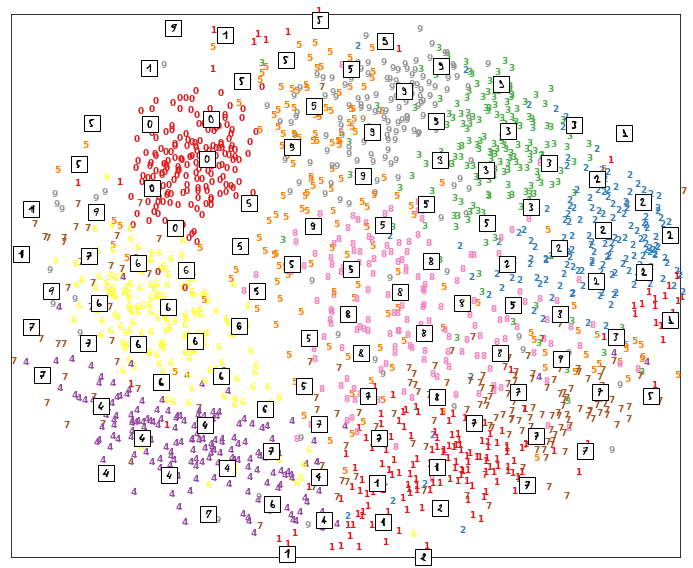

In [38]:
plot_embedding(Xmds,y)

# t-SNE
t-distributed Stochasitc Neiborhood Embedding

Ideologically similar to MDS, but with two differences:
* It only cares about close points. The distant points aren't as important.
* It uses a different notion of distance (like geodesic distance in graph) formulated through likelihood.


In short, it tries to preserve local structure, giving up on global structure.

In [39]:
from sklearn.manifold import TSNE

In [42]:
%%time
tsne = TSNE()
Xtsne = tsne.fit_transform(X)

CPU times: user 14.6 s, sys: 1.2 s, total: 15.8 s
Wall time: 13.2 s


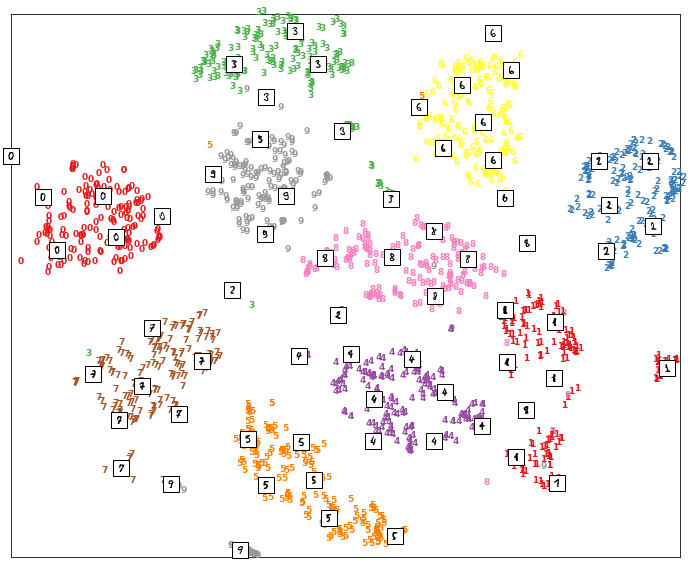

In [43]:
plot_embedding(Xtsne,y)

# Tuning it
 * t-SNE зависит depends on perplexity ~ how many neighbors to take in account
   * See how result changing if you scale perplexity between 1 and 100


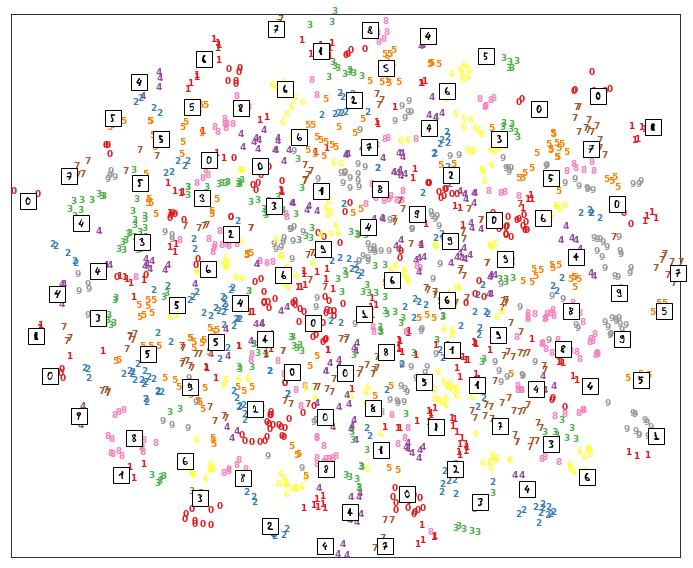

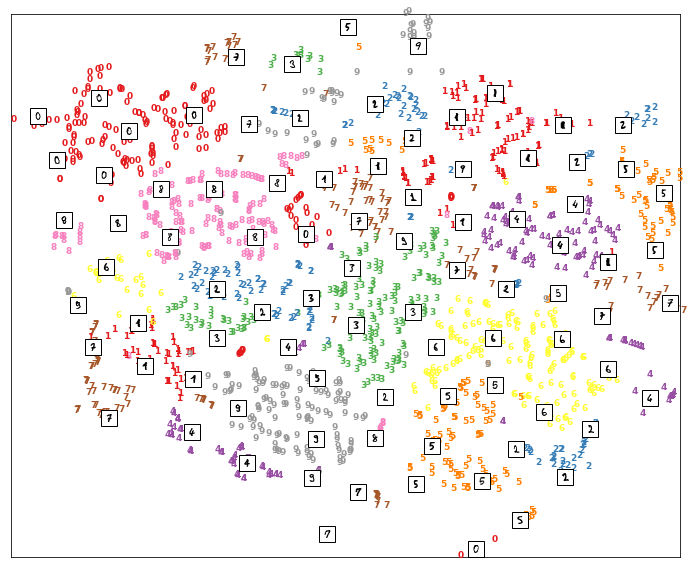

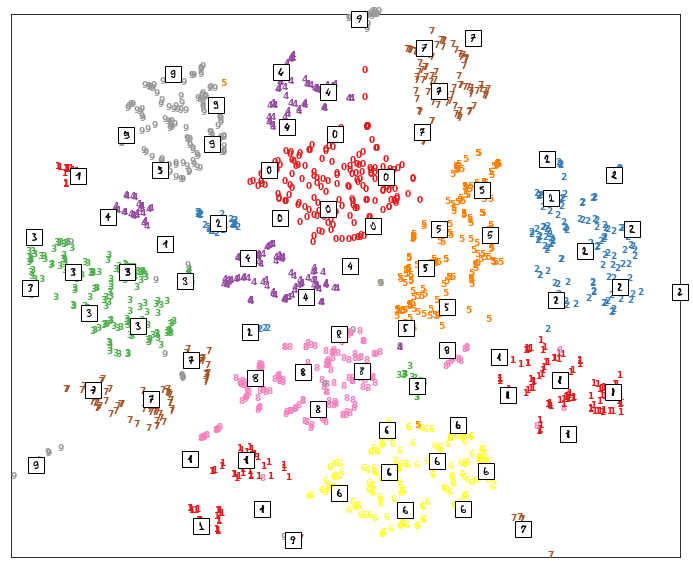

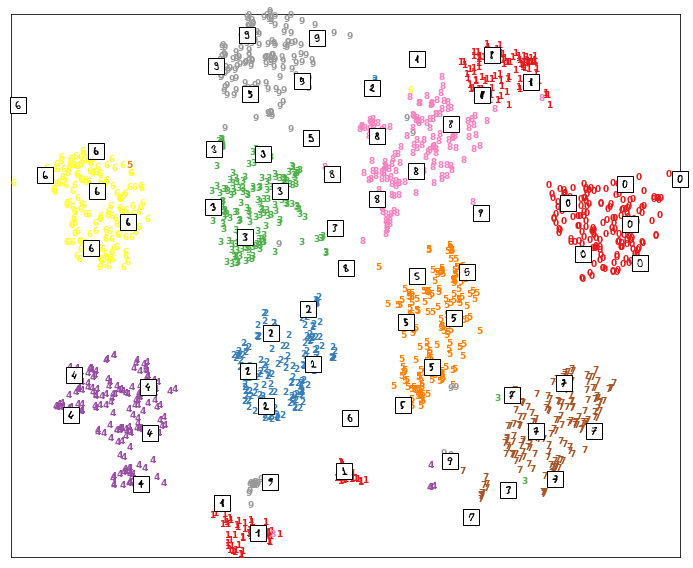

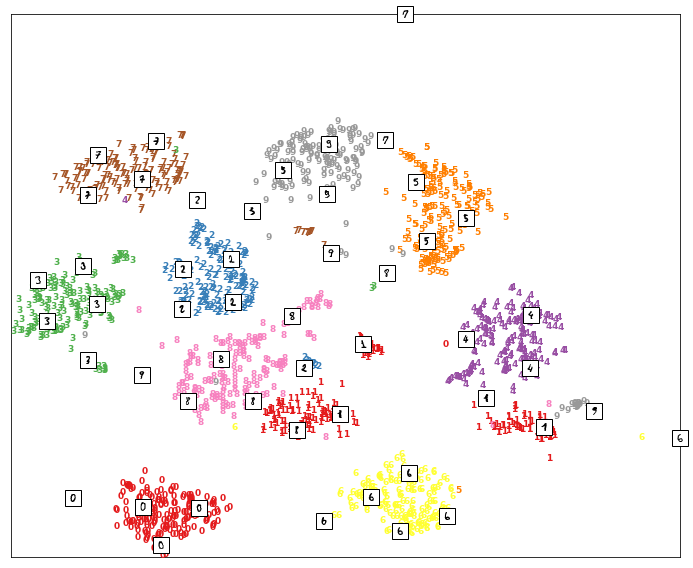

In [45]:
#<Try 5 different perplexities>
perp = (1,5,10,50,100)
for i in perp:
    tsne = TSNE(perplexity=i)
    Xtsne = tsne.fit_transform(X)
    plot_embedding(Xtsne,y)

 * Попробуйте сперва выделить несколько главных компонент с PCA, и только потом применить TSNE
   * Для начала, 64D изначально -> 16D после PCA -> 2D после TSNE


In [ ]:
<PCA_or_LDA->tsne>

There's a lot more to manifold learning.

* Sklearn page - http://scikit-learn.org/stable/modules/manifold.html
* Interactive demo - http://distill.pub/2016/misread-tsne/